In [3]:
import pandas as pd
from textblob import TextBlob
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


In [4]:
# Get the parent directory (project root)
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the project root to the system path for relative imports
if project_root not in sys.path:
    sys.path.append(project_root)

# Define the path to the stock data directory relative to the project root
data_dir = os.path.join(project_root, "Data", "yfinance_data")

# Function to load and prepare a single stock file
def load_stock_data(file_path):
    """
    Load a single stock CSV file, parse dates, and set the index.
    Args:
        file_path (str): Path to the stock data file.
    Returns:
        pd.DataFrame: Cleaned stock data.
    """
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Ensure the required columns are present
    required_columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"Missing required columns in {file_path}")
    
    # Parse dates and set as index
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Keep only the relevant columns
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    
    # Handle missing values (e.g., drop rows with NaN)
    df.dropna(inplace=True)
    
    return df

# Load all stock data files into a dictionary
stock_data = {}
for file_name in os.listdir(data_dir):
    if file_name.endswith(".csv"):  # Only process CSV files
        stock_name = file_name.split('_')[0]  # Use the stock ticker as the key
        file_path = os.path.join(data_dir, file_name)
        stock_data[stock_name] = load_stock_data(file_path)

# Example: Display data for all stocks
for ticker, df in stock_data.items():
    print(f"Data for {ticker}:\n", df.head())


Data for AAPL:
                 Open      High       Low     Close     Volume
Date                                                         
1980-12-12  0.128348  0.128906  0.128348  0.128348  469033600
1980-12-15  0.122210  0.122210  0.121652  0.121652  175884800
1980-12-16  0.113281  0.113281  0.112723  0.112723  105728000
1980-12-17  0.115513  0.116071  0.115513  0.115513   86441600
1980-12-18  0.118862  0.119420  0.118862  0.118862   73449600
Data for AMZN:
                 Open      High       Low     Close      Volume
Date                                                          
1997-05-15  0.121875  0.125000  0.096354  0.097917  1443120000
1997-05-16  0.098438  0.098958  0.085417  0.086458   294000000
1997-05-19  0.088021  0.088542  0.081250  0.085417   122136000
1997-05-20  0.086458  0.087500  0.081771  0.081771   109344000
1997-05-21  0.081771  0.082292  0.068750  0.071354   377064000
Data for TSLA:
                 Open      High       Low     Close     Volume
Date           

In [6]:
# Load the news data
news_data = pd.read_csv("../Data/modularization-demo/data/raw_analyst_ratings.csv")

# Convert 'date' to datetime and ensure it's in the correct format, then extract just the date (ignore time)
news_data['date'] = pd.to_datetime(news_data['date'], errors='coerce').dt.date  # Normalize to date only

# Check if there are any issues after conversion
print(news_data['date'].head())

# Perform sentiment analysis on the 'headline' column
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Returns polarity (-1 to 1)

# Apply sentiment analysis
news_data['sentiment'] = news_data['headline'].apply(get_sentiment)

# Aggregate sentiments by date
daily_sentiment = news_data.groupby('date')['sentiment'].mean().reset_index()

# Display sentiment data
print(daily_sentiment.head())


0    2020-06-05
1    2020-06-03
2    2020-05-26
3    2020-05-22
4    2020-05-22
Name: date, dtype: object
         date  sentiment
0  2011-04-27   0.000000
1  2011-04-28   0.068182
2  2011-04-29   0.166667
3  2011-04-30   0.500000
4  2011-05-01   0.000000


In [7]:
# Calculate daily returns for each stock
for ticker, df in stock_data.items():
    df['daily_returns'] = df['Close'].pct_change() * 100  # Percentage change in Close Price


In [9]:
# Ensure that 'date' in daily_sentiment is of type datetime64[ns]
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])

# Merge the stock data with sentiment data on the 'date' column
merged_data = {}
for ticker, df in stock_data.items():
    # Merge on the date (index in stock data and 'date' in sentiment data)
    stock_sentiment = pd.merge(df, daily_sentiment, left_index=True, right_on='date', how='inner')
    merged_data[ticker] = stock_sentiment

# Display merged data for AAPL as an example
print(merged_data['AAPL'].head())


        Open       High        Low      Close      Volume  daily_returns  \
0  12.580000  12.583929  12.396429  12.505357   356213200      -0.077056   
1  12.363929  12.491071  12.340000  12.383929   360959200      -0.971004   
2  12.385000  12.641071  12.381071  12.504643  1006345200       0.974765   
5  12.490714  12.516786  12.339286  12.367143   442713600      -1.099598   
6  12.428214  12.496071  12.343571  12.435714   313348000       0.554462   

        date  sentiment  
0 2011-04-27   0.000000  
1 2011-04-28   0.068182  
2 2011-04-29   0.166667  
5 2011-05-02  -0.009259  
6 2011-05-03   0.000000  


In [11]:
from scipy.stats import pearsonr

# Perform correlation analysis between sentiment and stock returns
correlation_results = {}

for ticker, df in merged_data.items():
    # Drop rows where either sentiment or daily_returns is NaN
    df_clean = df.dropna(subset=['sentiment', 'daily_returns'])

    # Calculate Pearson correlation between sentiment and daily returns
    if len(df_clean) > 1:  # Ensure there are enough data points for correlation
        correlation, _ = pearsonr(df_clean['sentiment'], df_clean['daily_returns'])
        correlation_results[ticker] = correlation
    else:
        correlation_results[ticker] = None  # Not enough data points for correlation

# Display the correlation results
for ticker, correlation in correlation_results.items():
    if correlation is not None:
        print(f"Correlation between sentiment and daily returns for {ticker}: {correlation}")
    else:
        print(f"Not enough data for {ticker} to calculate correlation.")


Correlation between sentiment and daily returns for AAPL: -0.0020328064776582557
Correlation between sentiment and daily returns for AMZN: -0.019444381937073242
Correlation between sentiment and daily returns for TSLA: 0.02773448884948581
Correlation between sentiment and daily returns for NVDA: 0.009262192621583914
Correlation between sentiment and daily returns for GOOG: 0.014278287212909585
Correlation between sentiment and daily returns for META: -0.006069691850633963
Correlation between sentiment and daily returns for MSFT: -0.012839404034983029


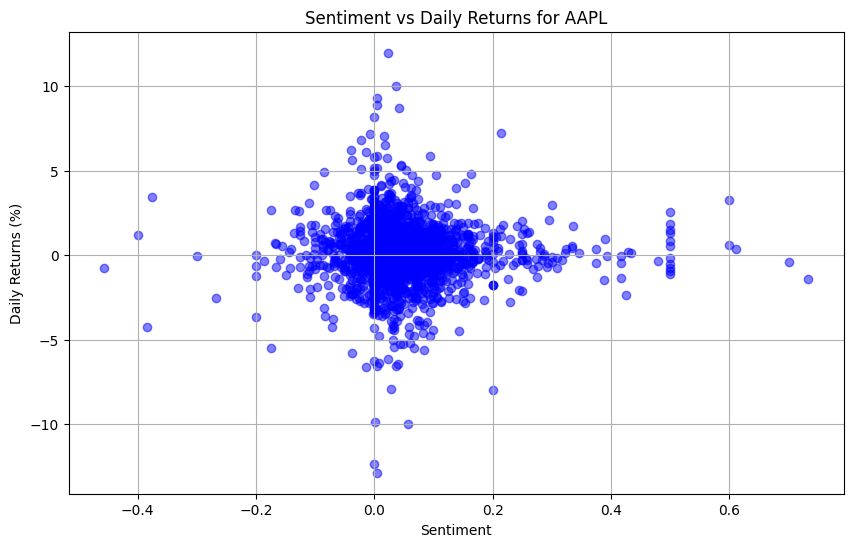

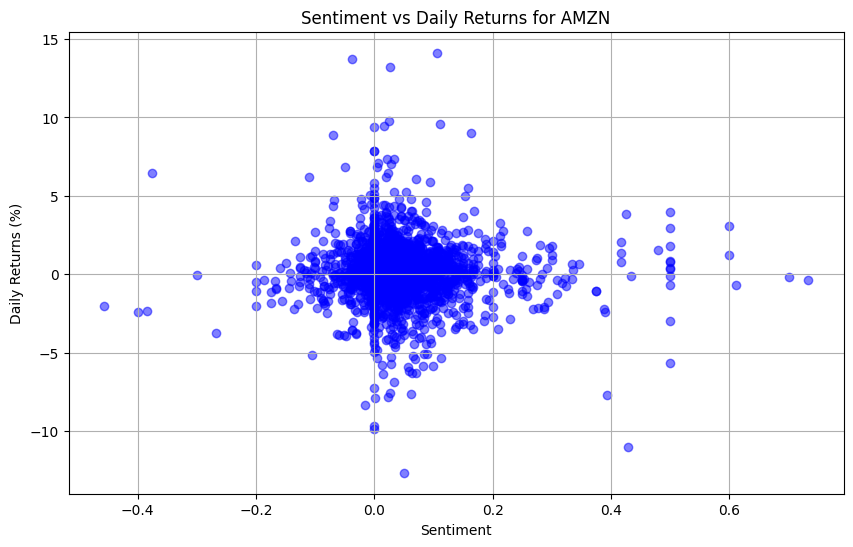

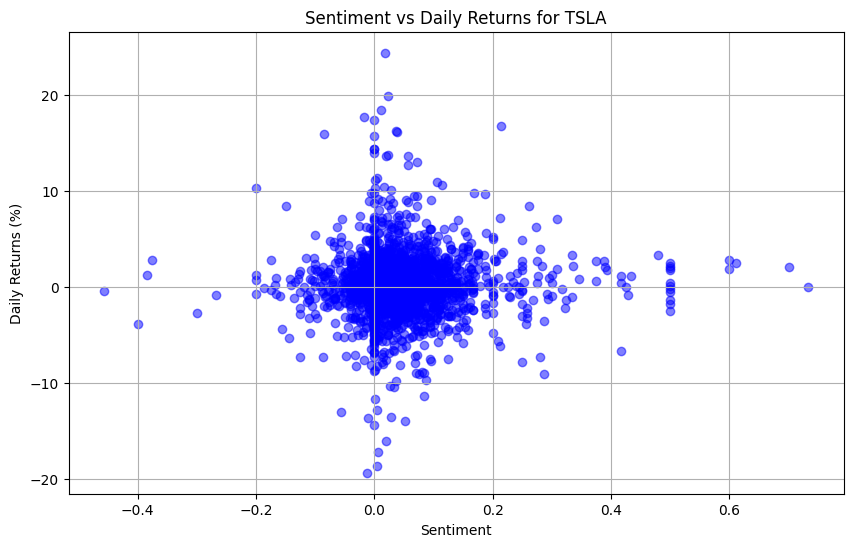

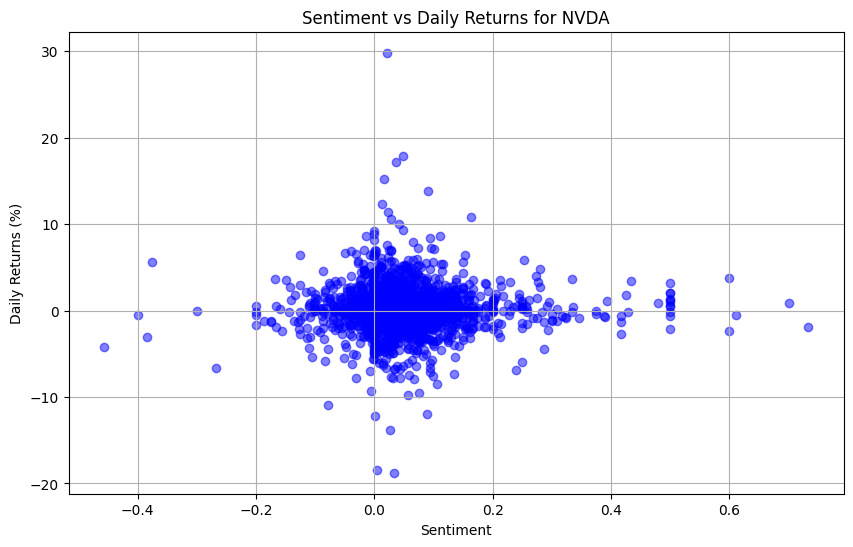

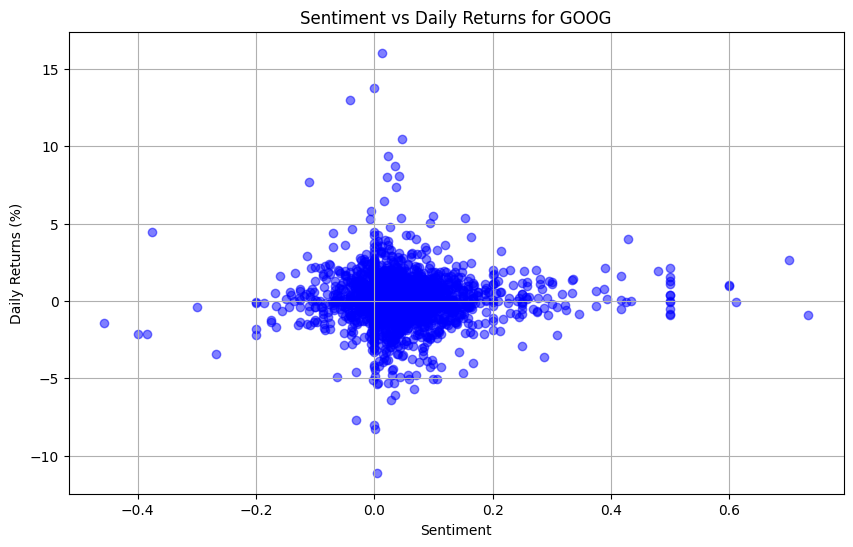

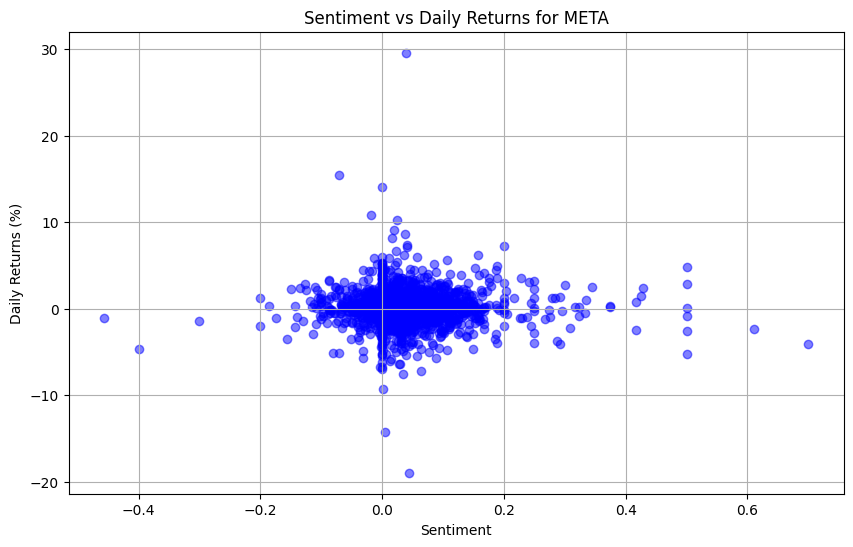

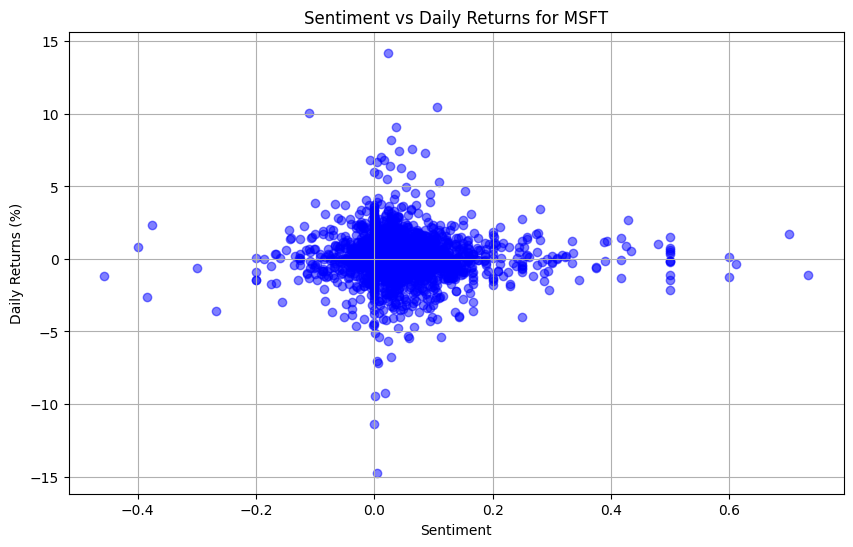

In [12]:
# Visualize the correlation between sentiment and stock returns
for ticker, df in merged_data.items():
    plt.figure(figsize=(10, 6))
    plt.scatter(df['sentiment'], df['daily_returns'], alpha=0.5, color='blue')
    plt.title(f'Sentiment vs Daily Returns for {ticker}')
    plt.xlabel('Sentiment')
    plt.ylabel('Daily Returns (%)')
    plt.grid(True)
    plt.show()
